<a href="https://colab.research.google.com/github/sivask01/CMPE257-Fall23-Sivakrishna-Yaganti/blob/homework-4/HW_4_%E2%80%93_SVMs_and_other_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW 4**


##**Re-usable Code**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
warnings.simplefilter("ignore")

def proper_df(input_data):
  data = []
  N, M = input_data.shape
  for i in range(N):
    string = input_data.iloc[i]
    list_at_i = [float(x) for x in string[0].split()]
    data.append(list_at_i)
  df = pd.DataFrame(data, columns = get_lables())
  return df

def get_lables():
  column_names = ['label']
  column_names.extend([str(x) for x in range(256)])
  return column_names

def calculate_intensity(df):
    pixel_values = df.iloc[:, 1:].values
    mean_absolute_intensity = np.mean(np.abs(pixel_values), axis=1)
    df['x1'] = mean_absolute_intensity
    return df

def calculate_symmetry(df):
    pixel_values = df.iloc[:, 1:].values
    n = pixel_values.shape[1]
    cms_symmetry = np.sum(np.abs(pixel_values - np.flip(pixel_values, axis=1)), axis=1) / n
    df['x2'] = cms_symmetry
    return df

def get_preprocessed_digits_dataframe(file_path):
  digit_train_data = pd.read_csv(file_path)
  digit_train_df = proper_df(digit_train_data)
  digit_train_df['label'] = digit_train_df['label'].apply(lambda x: -1.0 if x != 1.0 else x)
  return digit_train_df

def processor(file_path):
  binary_filtered_digit_train_df = get_preprocessed_digits_dataframe(file_path)
  binary_filtered_digit_train_df = binary_filtered_digit_train_df.rename(columns={'label': 'y'})
  binary_filtered_digit_train_df = calculate_intensity(binary_filtered_digit_train_df)
  binary_filtered_digit_train_df = calculate_symmetry(binary_filtered_digit_train_df)
  train_df = binary_filtered_digit_train_df[['x1', 'x2', 'y']]
  positive_train_df = train_df[train_df['y'] == 1.0]
  negative_train_df = train_df[train_df['y'] == -1.0]
  return train_df

In [3]:
class Processed_data:
  def __init__(self, train_df=None, test_df=None):
    self.kernels = ['linear', 'poly', 'rbf']
    self.C = [0.01, 0.1, 1, 10, 100, 1000]
    self.cv_size = 5
    if train_df is not None:
      self.X_train = train_df[['x1', 'x2']]
      self.Y_train = train_df[['y']]
    if test_df is not None:
      self.X_test = test_df[['x1', 'x2']]
      self.Y_test = test_df[['y']]

train_df = processor('/content/ZipDigits.train')
test_df = processor('/content/ZipDigits.test')
processed_data = Processed_data(train_df, test_df)

## **Task-1**

In [4]:
class SVM_Classifier(Processed_data):
  def __init__(self, df):
    super().__init__()
    self.df = df
    self.X = df[['x1', 'x2']]
    self.Y = df[['y']]
    self.error = []

  def lp_1(self, C=1):
    for index, kernel in enumerate(self.kernels):
      kernal_errors = []
      for C in self.C:
        svm_clf = SVC(kernel=kernel, C=C)
        X_train = self.df[['x1', 'x2']]
        y_train = self.df[['y']]
        svm_clf.fit(X_train, y_train)
        y_pred_train = svm_clf.predict(X_train)
        train_error = 1 - accuracy_score(y_train, y_pred_train)
        kernal_errors.append(train_error)
      self.error.append(kernal_errors)
    c_1_index = self.C.index(1)
    for index, kernel in enumerate(self.kernels):
      print(f"Training error with {kernel} kernel and C={1}: {self.error[index][c_1_index]:.4f}")
SVM_classifier = SVM_Classifier(train_df)

###LP-1

In [5]:
SVM_classifier.lp_1()

In [ ]:
SVM_classifier.error

[[0.13786008230452673,
  0.03827160493827164,
  0.02400548696844995,
  0.013854595336076803,
  0.012071330589849105,
  0.011522633744855959],
 [0.01275720164609051,
  0.012071330589849105,
  0.012071330589849105,
  0.012345679012345734,
  0.012208504801097364,
  0.012208504801097364],
 [0.03566529492455417,
  0.020850480109739333,
  0.013717421124828544,
  0.011659807956104218,
  0.0113854595336077,
  0.011659807956104218]]

### HP-1

Based on the obtained results, it appears that the polynomial (poly) kernel stands out as the most effective among the tested kernels for distinguishing '1' from other digits in the digits dataset. It demonstrates the highest accuracy at 98.50% and the lowest training error at 1.50% among the three kernels under consideration.
However, relying solely on accuracy or training error as the criteria for kernel selection may not always be the most prudent approach.

**Overfitting Challenge**: Achieving high accuracy or low training error on the training set does not necessarily guarantee robust generalization to unseen data (such as the test set or real-world data). Overfit models may underperform when faced with new, unseen samples.

**Dataset Sensitivity**: The model's performance can significantly vary depending on the specific features and characteristics of the dataset. While the polynomial kernel nearly achieved perfect predictions in our current analysis, such performance may not be guaranteed on entirely new and unseen data.

**Hyperparameter Tuning**: SVM performance, especially with different kernels, is highly contingent on the choice of hyperparameters, such as C, degree (for the polynomial kernel), or gamma (for the RBF kernel). Default parameters may not always be optimal for all datasets.

**Cross-Validation**: To provide a more accurate and comprehensive assessment of model performance and kernel suitability, it is essential to incorporate cross-validation techniques, such as k-fold cross-validation.

##**Task-2**

In [ ]:
class Cross_Validation(Processed_data):
  def __init__(self, df):
    super().__init__()
    self.df = df
    self.X = df[['x1', 'x2']]
    self.Y = df[['y']]
    self.error = []

  def lp_1(self):
    X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
    for kernel in self.kernels:
      kernal_errors = []
      for C in self.C:
          svm_clf = SVC(kernel=kernel, C=C)
          scores = cross_val_score(svm_clf, X_train, y_train, cv=self.cv_size)
          cross_val_error = 1 - np.mean(scores)
          print(f"Cross-validation error with {kernel} kernel and C={C}: {cross_val_error:.4f}")
          kernal_errors.append(cross_val_error)
      self.error.append(kernal_errors)
cross_validation = Cross_Validation(train_df)

###LP-1

In [ ]:
cross_validation.lp_1()

Cross-validation error with linear kernel and C=0.01: 0.1370
Cross-validation error with linear kernel and C=0.1: 0.0420
Cross-validation error with linear kernel and C=1: 0.0283
Cross-validation error with linear kernel and C=10: 0.0156
Cross-validation error with linear kernel and C=100: 0.0132
Cross-validation error with linear kernel and C=1000: 0.0120
Cross-validation error with poly kernel and C=0.01: 0.0134
Cross-validation error with poly kernel and C=0.1: 0.0122
Cross-validation error with poly kernel and C=1: 0.0127
Cross-validation error with poly kernel and C=10: 0.0127
Cross-validation error with poly kernel and C=100: 0.0125
Cross-validation error with poly kernel and C=1000: 0.0125
Cross-validation error with rbf kernel and C=0.01: 0.0381
Cross-validation error with rbf kernel and C=0.1: 0.0245
Cross-validation error with rbf kernel and C=1: 0.0151
Cross-validation error with rbf kernel and C=10: 0.0129
Cross-validation error with rbf kernel and C=100: 0.0130
Cross-valid

In [ ]:
cross_validation.error

[[0.1370027088560336,
  0.04201005054669493,
  0.02829086323290153,
  0.01560274618915547,
  0.013202255861226697,
  0.012002304658850216],
 [0.013373929428641573,
  0.01217368426467702,
  0.01268826402453982,
  0.012688117043745839,
  0.012516737437918812,
  0.012516737437919034],
 [0.03806493905441377,
  0.024518454173593107,
  0.015088460390880742,
  0.012859496649572755,
  0.013030435313017619,
  0.012859202687984905]]

### LP-2

[[0.1370027088560336, 0.04201005054669493, 0.02829086323290153, 0.01560274618915547, 0.013202255861226697, 0.012002304658850216], [0.013373929428641573, 0.01217368426467702, 0.01268826402453982, 0.012688117043745839, 0.012516737437918812, 0.012516737437919034], [0.03806493905441377, 0.024518454173593107, 0.015088460390880742, 0.012859496649572755, 0.013030435313017619, 0.012859202687984905]]


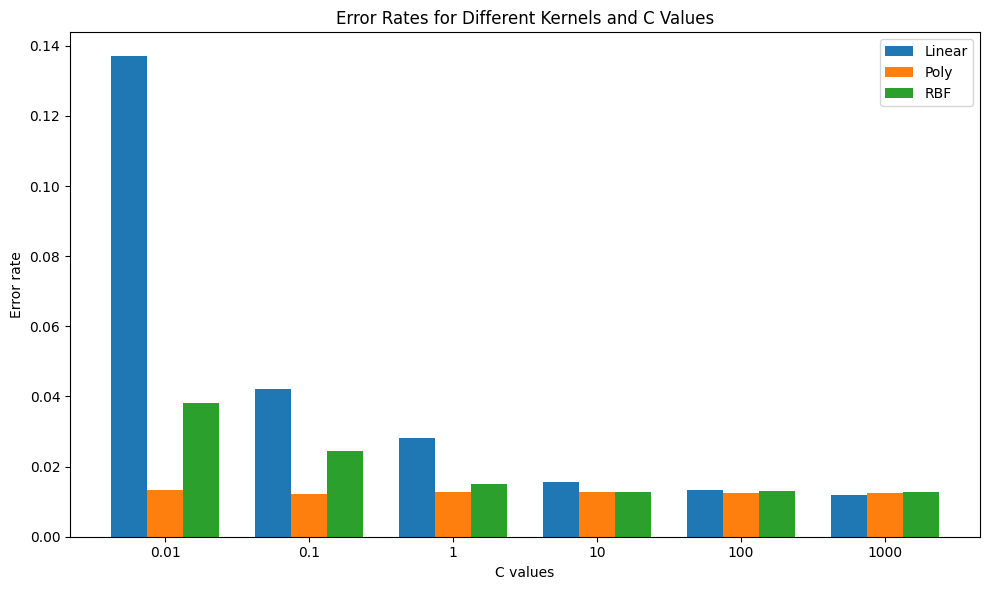

In [ ]:
bar_width = 0.25
index = range(len(processed_data.C))

plt.figure(figsize=(10, 6))
print(cross_validation.error)
plt.bar(index, cross_validation.error[0], width=bar_width, label='Linear')
plt.bar([i + bar_width for i in index], cross_validation.error[1], width=bar_width, label='Poly')
plt.bar([i + 2 * bar_width for i in index], cross_validation.error[2], width=bar_width, label='RBF')

plt.xlabel('C values')
plt.ylabel('Error rate')
plt.title('Error Rates for Different Kernels and C Values')
plt.xticks([i + bar_width for i in index], processed_data.C)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
1-0.012859496649572755

0.9871405033504272

#### I'd choose svm classfier with rbf kernl with C=10 for which I'm getting accuracy as (98.7%)0.9871405033504272


### HP

In [ ]:
[row[4] for row in cross_validation.error]

[0.013202255861226697, 0.012516737437918812, 0.013030435313017619]

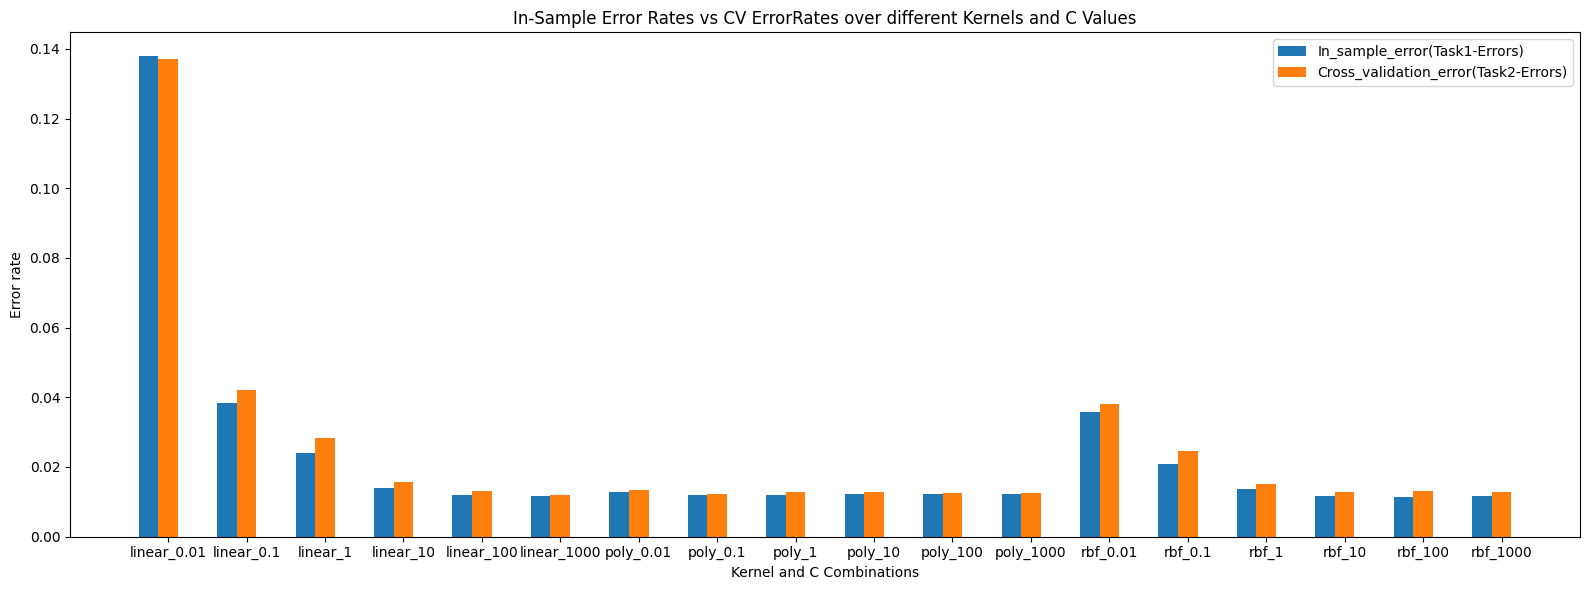

In [ ]:
bar_width = 0.25
# index of C for the choden model
reg_index = 4

# error_types = ["In_sample_error", "Cross_validation_error"]
index = range(len(processed_data.kernels)*len(processed_data.C))
x_ticks = []
in_sample_error = []
cv_error = []

for k_ind, kernel in enumerate(processed_data.kernels):
  for c_ind, c in enumerate(processed_data.C):
    x_ticks.append(f"{kernel}_{c}")
    in_sample_error.append(SVM_classifier.error[k_ind][c_ind])
    cv_error.append(cross_validation.error[k_ind][c_ind])

plt.figure(figsize=(16, 6))
plt.bar(index, in_sample_error, width=bar_width, label='In_sample_error(SVM_Classifier-Errors)')
plt.bar([i + bar_width for i in index], cv_error, width=bar_width, label='Cross_validation_error(Cross_Validation-Errors)')

plt.xlabel('Kernel and C Combinations')
plt.ylabel('Error rate')
plt.title('In-Sample Error Rates vs CV ErrorRates over different Kernels and C Values')
plt.xticks([i + bar_width for i in index], x_ticks)
plt.legend()

plt.tight_layout()
plt.show()

Observations:

-  As the normalization parameter increases, the cv and e_in error is getting reduced.

-  In almost every combination, the in-sample error is lesser than that in cv_error.

-  I think this is a sign of overfitting as we are getting very small error and this might not be the case when we introduce the unseen data to the model.

-  And, svm with poly kernel there is not a big change in error with any parameter C.

## **Task-3**

### LP-1

Final SVM:
  - Kernal : rbf
  - C : 10

In [ ]:
svm_clf = SVC(kernel='rbf', C=10)
svm_clf.fit(processed_data.X_train, processed_data.Y_train)

y_pred_train = svm_clf.predict(processed_data.X_train)

train_error = 1 - accuracy_score(processed_data.Y_train, y_pred_train)

print(f"In-sample error for the SVM model with rbf kernel and C=10 percentage is {train_error*100:.2f}")

In-sample error for the SVM model with rbf kernel and C=10 percentage is 1.17


### LP-2

In [ ]:
y_pred_train = svm_clf.predict(processed_data.X_test)

test_error = 1 - accuracy_score(processed_data.Y_test, y_pred_train)

print(f"Final test error for the SVM model with rbf kernel and C=10 percentage is {test_error*100:.2f}")

Final test error for the SVM model with rbf kernel and C=10 percentage is 1.60


##**Task-4**

### HP-1

In [ ]:
models = ["PLA", "pocket", "O(x^3) pocket", "NN-SGD", "NN-MBGD", "NN-BGD"]
accuracy = [63.42, 66.94, 95.32, 96.69, 98.71, 99.06]
test_errors = [100-x for x in accuracy]
test_errors

[36.58,
 33.06,
 4.680000000000007,
 3.3100000000000023,
 1.2900000000000063,
 0.9399999999999977]

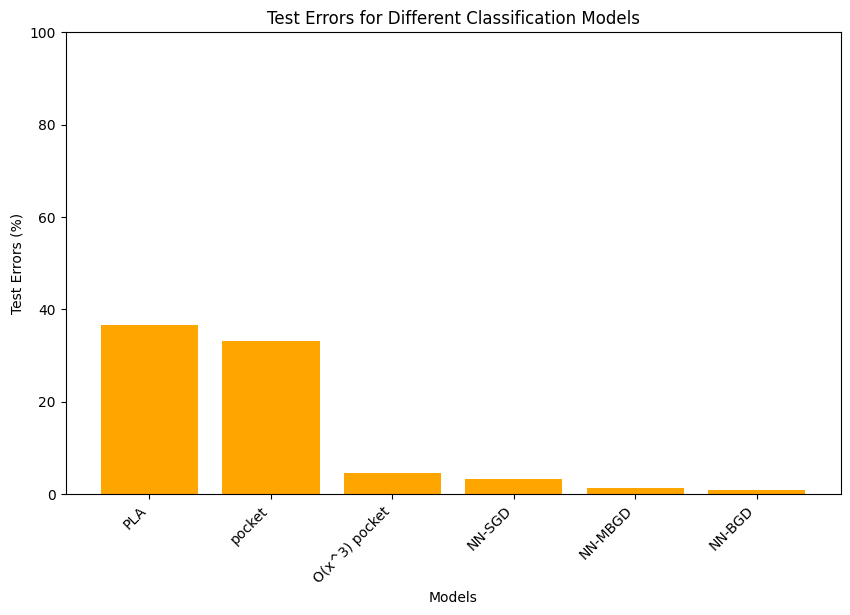

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(models, test_errors, color='orange')
plt.xlabel('Models')
plt.ylabel('Test Errors (%)')
plt.title('Test Errors for Different Classification Models')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.show()

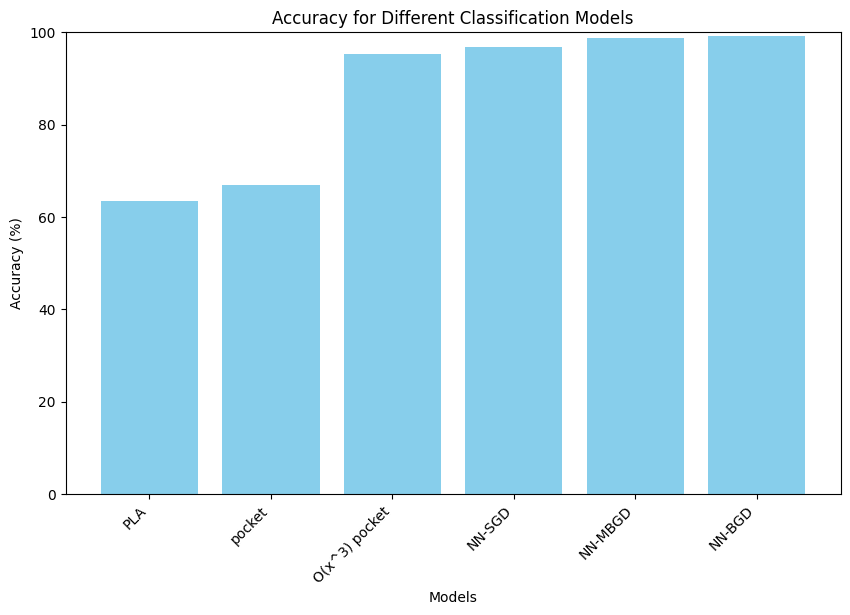

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Classification Models')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.show()

**Optimal Test Error**: The NN-BGD model demonstrates the most favorable test error, achieving a low of 0.94%.

**Suboptimal Test Error**: On the other end of the spectrum, the PLA model exhibits a less favorable test error, peaking at 36.58%.

Numerous factors contribute to the observed variations in model performance:

- The simplicity of Pocket and PLA models, which consider only two features and linear relationships, contrasts with the enhanced complexity introduced by the incorporation of eight features through the construction of a 3rd order polynomial. This transformation leads to a notable performance improvement of 33%.

- The utilization of polynomial feature transformation (O(x^3) pocket) likely enhances the model's capacity to capture nonlinear relationships within the data, contributing to its superior performance compared to the pocket and PLA algorithms.

- The trend of increasing model complexity corresponds to more effective predictions. For instance, neural networks (NN-SGD, NN-MBGD, NN-BGD) exhibit the capability to learn intricate patterns in the data, resulting in lower errors when contrasted with simpler models such as PLA.

### HP-2

In [ ]:
test_df.shape

(2006, 3)

In [ ]:
train_df.shape

(3688, 3)


**Effective Strategies in Model Selection for Digit Classification:**

Navigating the intricacies of digit classification demanded a thoughtful and hands-on approach, especially considering the dataset's size—around 2000 samples for testing and 3700 samples for training. The pursuit of the ideal classification model involved a series of strategic moves.

**Insights from Cross-Validation:** The incorporation of cross-validation, particularly when applying the Pocket algorithm with 3rd order transformed data, emerged as a pivotal step. This technique not only contributed to preventing overfitting but also proved its mettle in subsequent stages of the analysis.

**Fine-Tuning with Hyperparameter Exploration:** The commitment to optimizing model performance led through an exhaustive exploration of different learning rates, regularization strengths, and epochs for neural networks. In the realm of non-linear models, such as polynomial regression, various polynomial orders were delved into to strike that elusive balance between model complexity and accurate predictions.

**Balancing Act: Model Complexity vs. Dataset Size:** A nuanced evaluation of model complexity relative to dataset size became a guiding principle. Recognizing the potential overfitting challenges with more complex models on smaller datasets, there was diligence in striking a careful equilibrium.

Moreover, specific efforts were made to elevate the performance of each model:

**Perceptron (PLA) and Pocket Algorithm:**
- Incrementing the number of weight updates emerged as a reliable strategy for enhancing accuracy, though a plateau effect was observed after a certain threshold.
- Experimentation with higher-order polynomials yielded a significant performance boost, underscoring the model's ability to grasp complex relationships.

**Neural Networks (SGD, MBGD, BGD):**
- Adjusting the learning rate became an art form, carefully balancing convergence speed and the avoidance of overshooting, particularly as experimentation with different gradient descent approaches unfolded.
- For MBGD, exploration of diverse batch sizes aimed at finding the sweet spot between computational efficiency and convergence speed.
- Varied weight initialization methods were explored to influence convergence speed and steer clear of local minima.

In conclusion, the approach was a hands-on journey, marked by iterative adjustments to parameters like iterations, epochs, and learning rates. This strategy, far from being algorithmically generated, mirrored a thoughtful and personalized exploration of the nuances within the digit classification challenge.